## Packages

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [10]:
#!pip install verstack
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from verstack import FeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import optuna

## Reading Dataset

In [4]:
## reading preprocessed data

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LLC Assignment/data_preprocessed.csv')
data

,Year,Month,households,subsidies,urban_popln,const_price,new_const_units,income,interest_rate,gdp,unemployment_rate,home_prices
0,1940,1,34949,0.159,72.247,23.200,1257,2399.7,1.22,15137,4.0,67.739
1,1941,1,39107,0.159,72.612,23.200,1074,2353.8,0.68,15204,4.0,67.739
2,1942,1,40532,0.176,71.508,22.900,1281,2399.7,1.15,15137,3.9,68.506
3,1943,1,40532,0.195,71.879,23.200,1302,2370.8,1.15,15204,3.9,68.506
4,1944,1,40532,0.195,71.879,22.500,1274,2399.7,1.15,15250,4.0,68.107
...,...,...,...,...,...,...,...,...,...,...,...,...
5064,2023,4,131202,40.185,83.084,335.032,1317,16770.5,3.71,66078,3.4,300.198
5065,2023,5,131202,44.147,82.459,333.980,1521,16764.6,4.81,66078,3.6,302.620
5066,2023,6,131202,44.147,82.873,331.729,1492,16770.5,4.60,65783,3.7,304.651
5067,2023,7,129224,40.185,83.084,331.729,1469,16764.6,5.24,66341,3.7,306.634


In [5]:
data.loc[:,'home_prices']

0        67.739
1        67.739
2        68.506
3        68.506
4        68.107
         ...   
5064    300.198
5065    302.620
5066    304.651
5067    306.634
5068    309.404
Name: home_prices, Length: 5069, dtype: float64

## Feature Engineering

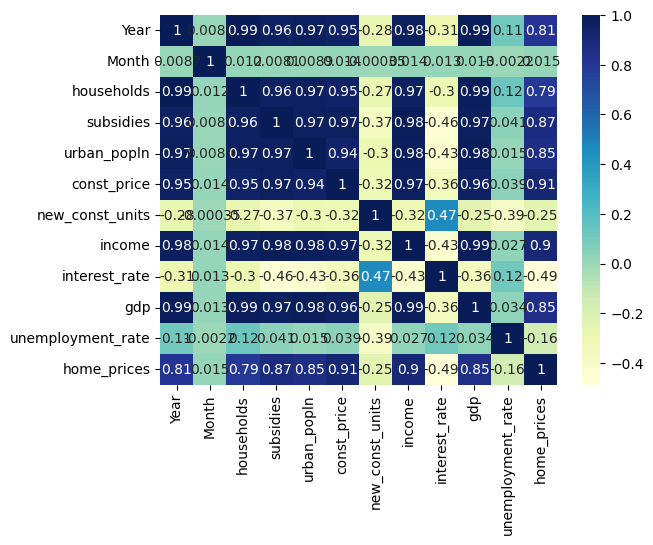

In [6]:
## Heatmap:

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

## Observations 1:

## Home Price has moderate negative correlation with interest rate and strong positive correlation with the factors Year, no. of households, subsidies, urban population, construction price, income, gdp.
## For some factors we see the magnitude of correlation is low. This might be due to the linear assumption with the target.



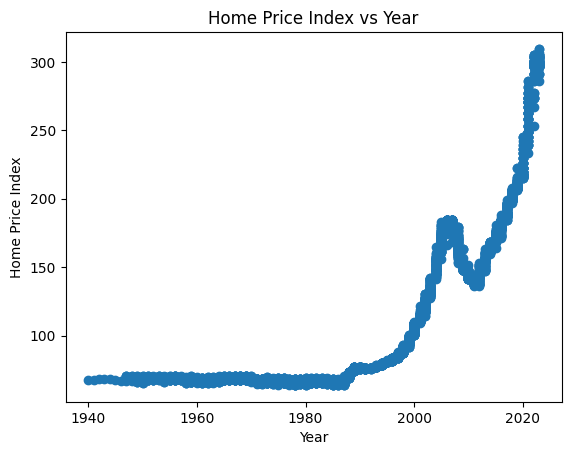

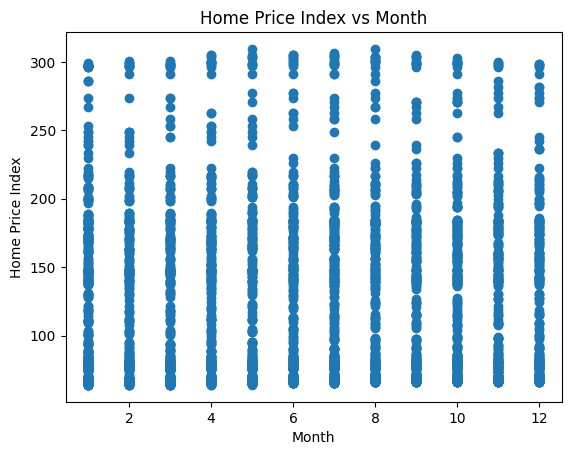

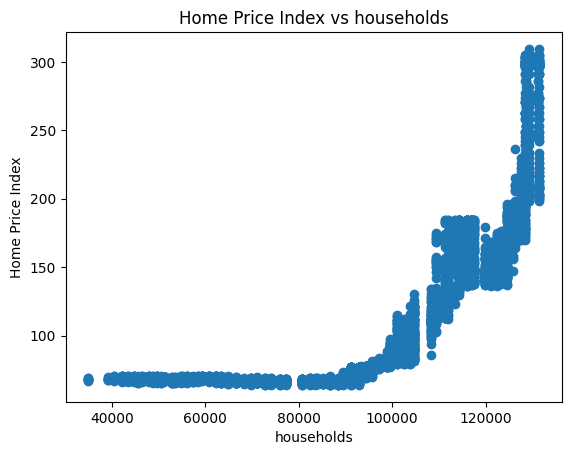

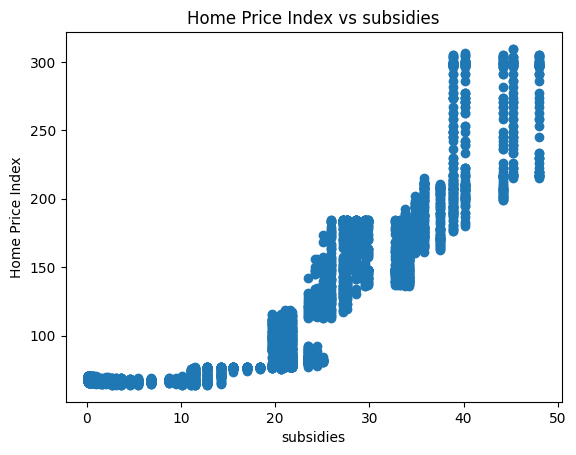

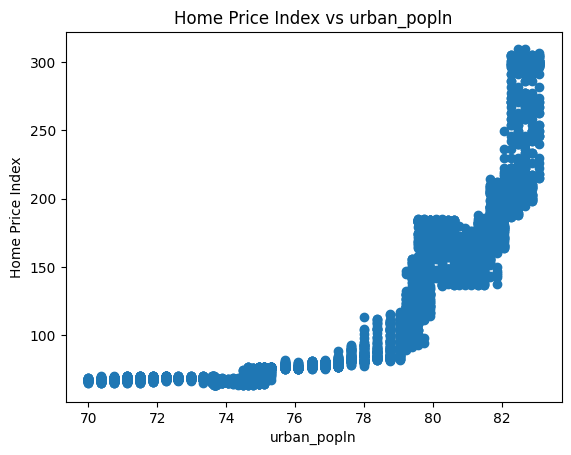

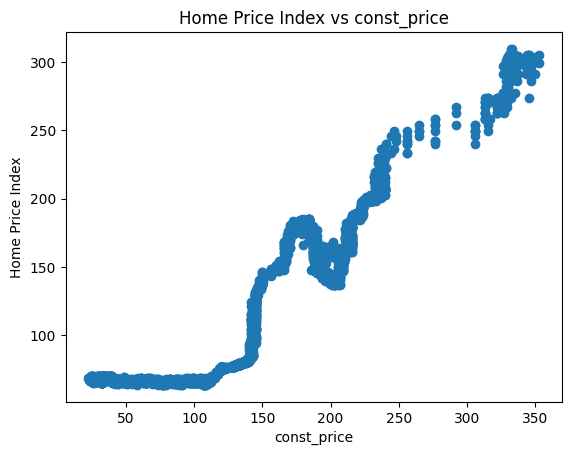

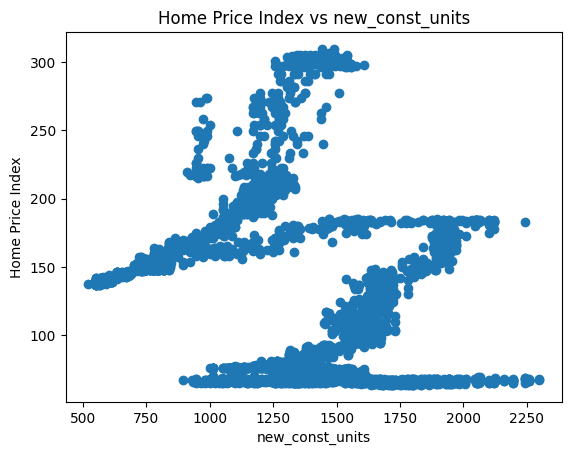

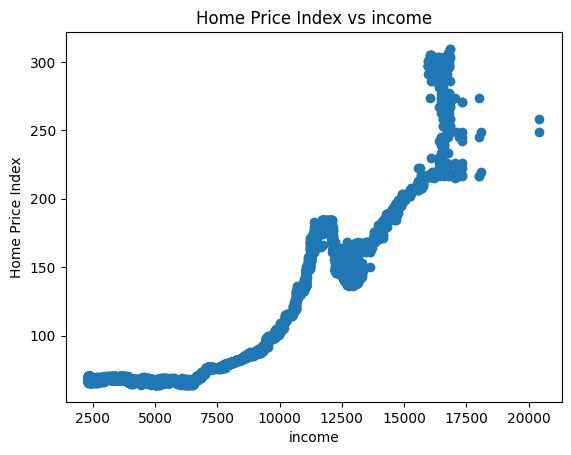

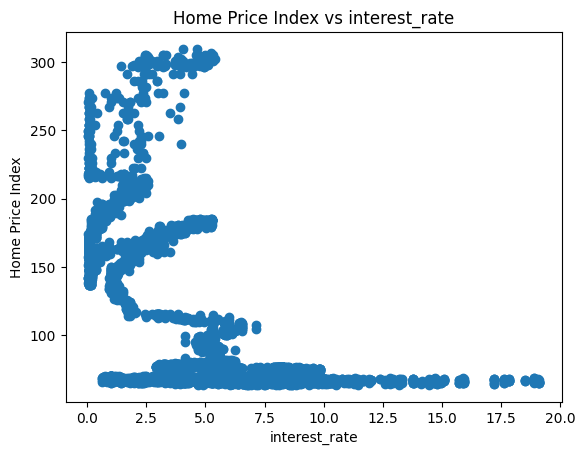

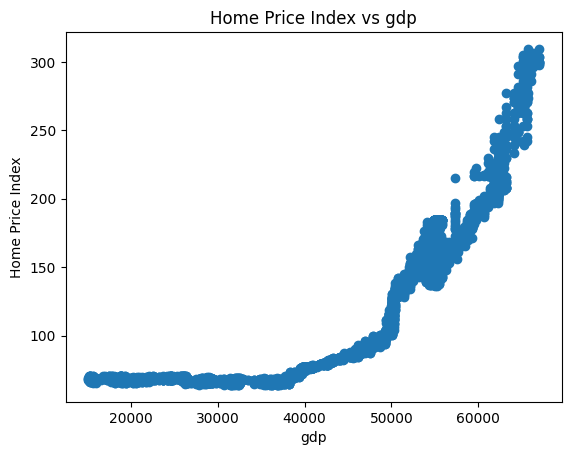

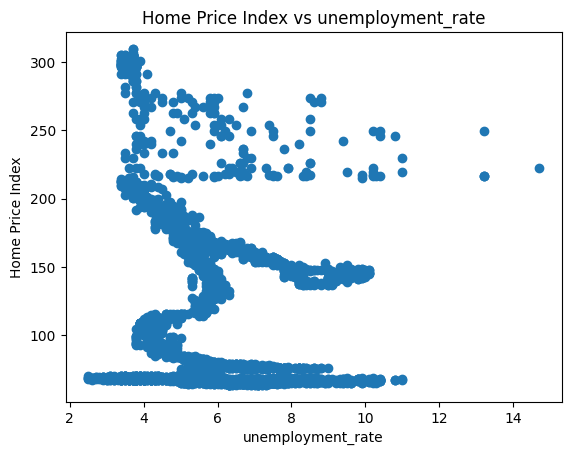

In [5]:
# Plotting scatter plots of the CASE-SHILLER index vs features

cols = data.columns
target = cols[-1]

feature = cols[:len(cols)-1]


for f in feature:
    plt.figure()
    plt.scatter(x = data[f], y = data[target])
    plt.xlabel(f)
    plt.ylabel("Home Price Index")
    plt.title(f"Home Price Index vs {f}")


## Observations 2:

## But when we plot features with the target 'Home Price' we see that only factor 'Month' has no effect on 'Home Prices'.
## The housing price is negatively skewed towards year showing a tolerance till the year 1990 but afterwards it increased exponentially. This tolerance may be the cumulative effect of income, interest rate, gdp etc.
## People falling around unemployment rate of 11-14 % could not afford the home price.
## Home Price is negatively skewed towards gdp per capita, urban population, no. of households. No. of Households may get affected due to area desirability like in urban areas we expect more houses to be constructed but due to increase in population house price is increasing. Also unemployment, interest taken from bank during the boom period and rate of income can have effects on housing prices and also there are other factors like government laws, crime-rates affecting location where houses can be constructed.
## Home Price Index is positively skewed towards interest rates signifying people are no longer looking for large apartments due to the high interest rates. One can also think in this way that due to rise of unemployment over the years people can not take risk of paying at high interest for large apartments.
## Finally, we see here all these factors affecting each other and rise in housing price is due to their individual as well as their cumulative effects.

## Data Cleaning

In [6]:
## Droping Month column:
data = data.drop(['Month'],axis=1)

## Splitting Dataset into 90% train and 10% test data

In [16]:
## Data Splitting:
feature = data.columns
target = feature[-1]
feature = feature[:len(feature)-1]
X_train, X_test, Y_train, Y_test = train_test_split(data[feature], data[target], test_size=0.1, random_state=42)
(X_train.shape, X_test.shape) , (Y_train.shape, Y_test.shape)


(((4562, 10), (507, 10)), ((4562,), (507,)))

## Model Building

### Linear Regression

In [19]:
# Create a pipeline with a standard scaler and linear regression
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('regressor', LinearRegression())  # Linear Regression model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 155.20779898501087


### Random Forest Regression

In [33]:
# Create a pipeline with a standard scaler and random forest regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('regressor', RandomForestRegressor())  # Random Forest Regressor
])

# Fit the pipeline to the training data
pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.6344961362015518


## XgBoost Regression

In [34]:
# Create a pipeline with a standard scaler and random forest regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('regressor', XGBRegressor())  # Random Forest Regressor
])

# Fit the pipeline to the training data
pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3.478242572915501


### Light Gradient Boost

In [35]:
# Create a pipeline with a standard scaler and random forest regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('regressor', LGBMRegressor())  # Random Forest Regressor
])

# Fit the pipeline to the training data
pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 10
[LightGBM] [Info] Start training from score 110.320858
Mean Squared Error: 2.6359241943093368


## HyperParameter Tuning Light GBM

In [39]:
scaler = StandardScaler()
scaler.fit(data[feature])
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mse",
        "n_estimators": trial.suggest_int("n_estimators",50,1000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=False),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params)
    model.fit(X_train_scaled, Y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(Y_test, predictions, squared=False)
    return mse

In [40]:
search = optuna.create_study(direction='minimize')
search.optimize(objective, n_trials=50)

[I 2023-11-26 15:09:24,039] A new study created in memory with name: no-name-5eab57ac-0e52-4c20-9406-d4163aa7b79f
[I 2023-11-26 15:09:24,500] Trial 0 finished with value: 1.9218728424950742 and parameters: {'n_estimators': 94, 'learning_rate': 0.0917546103280497, 'num_leaves': 244, 'subsample': 0.43004110505822724, 'colsample_bytree': 0.2572401979014637, 'min_data_in_leaf': 41}. Best is trial 0 with value: 1.9218728424950742.
[I 2023-11-26 15:09:25,214] Trial 1 finished with value: 12.237540926962387 and parameters: {'n_estimators': 937, 'learning_rate': 0.061003124479856535, 'num_leaves': 73, 'subsample': 0.06911628308741122, 'colsample_bytree': 0.8648638416357032, 'min_data_in_leaf': 79}. Best is trial 0 with value: 1.9218728424950742.
[I 2023-11-26 15:09:26,369] Trial 2 finished with value: 3.4318745051128854 and parameters: {'n_estimators': 740, 'learning_rate': 0.03690577071987672, 'num_leaves': 106, 'subsample': 0.35790506310223963, 'colsample_bytree': 0.582270827554566, 'min_dat

In [46]:
print('Best hyperparameters:', search.best_params)
print('Best RMSE:', search.best_value)


Best hyperparameters: {'n_estimators': 69, 'learning_rate': 0.089918314721017, 'num_leaves': 637, 'subsample': 0.7701734708281914, 'colsample_bytree': 0.8065223653876706, 'min_data_in_leaf': 45}
Best RMSE: 1.4623170741043308


### Parameters: n_estimators: 69, learning_rate: 0.089918314721017, num_leaves: 637, subsample: 0.7701734708281914, colsample_bytree: 0.8065223653876706, min_data_in_leaf: 45

In [47]:
## Lets test once this :

# Create a pipeline with a standard scaler and random forest regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('regressor', LGBMRegressor(n_estimators=69, bagging_freq= 1, learning_rate=0.089918314721017, num_leaves= 637,
                                subsample= 0.7701734708281914, colsample_bytree= 0.8065223653876706, min_data_in_leaf= 45))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'\nMean Squared Error: {mse}')

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 10
[LightGBM] [Info] Start training from score 110.320858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

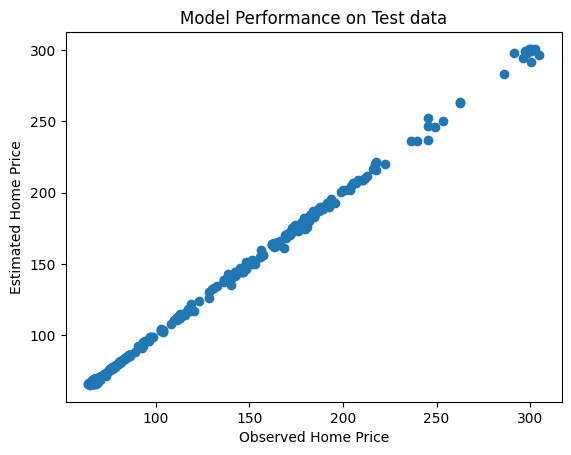

In [51]:
## Plot the predicted vs test samples:

x=Y_test
plt.figure()
plt.scatter(x = Y_test, y = Y_pred)
plt.xlabel('Observed Home Price')
plt.ylabel("Estimated Home Price")
plt.title("Model Performance on Test data")
plt.show()

## In the above graph the visual looks like a straight line which means predicted and observed coincide with one another with MSE 2.106 approx.
## This model delivering great accuracy in estimating the home prices. Hence our proposed model will be tuned light gbm.

## Our Model will be up and running in the server with few more of alloted time.

### ---------------------------------------------------------------------------------THE END--------------------------------------------------------------------------------------